# **Unified classification and risk-stratification in Acute Myeloid Leukemia**


>>> # **Tutorial for Bayesian Dirichlet Process for finding molecular clusters** : 

### This notebook is independent of the paper and can be used for clustering any dataset

In [8]:
library(hdp)
library(ggplot2)
library('ggrepel')
library(dplyr)

library('IRdisplay')
source('src/tools.R')     
source('src/hdp_tools.R')    ## containing useful functions for HDP
library(gridExtra)

In [9]:
df_hdp1 <- read.table("data/aml_bdp1.tsv")

df_molecular <- read.table("data/aml_molecular_bdp.tsv")

genes_columns <-colnames(df_molecular)[grepl("^[[:upper:]]", colnames(df_molecular))]

cytos_columns <- colnames(df_molecular)[!grepl("^[[:upper:]]", colnames(df_molecular))]

# BDP : A clustering tool to identify dominant molecular drivers 

# I) BDP1 : BDP algorithm applied on 2150 Patients and 153 genes and cytos

In [10]:
# HDP Parameters

data <- df_hdp1
posterior_samples <- 250
initial_clusters <- 17
burn <- 7000
chains <- 3
base_dist <- prepare_distributions(df_hdp1)$gaussian
aa <- 0.5
ab <-1.5


Number of components: 10
Number of NA rows   : 51


,values,count,freq
,<fct>,<int>,<chr>
2,1,833,38.7441860465116
3,2,418,19.4418604651163
4,3,229,10.6511627906977
5,4,128,5.95348837209302
6,5,114,5.30232558139535
7,6,114,5.30232558139535
1,0,96,4.46511627906977
9,8,61,2.83720930232558
12,NaN,51,2.37209302325581


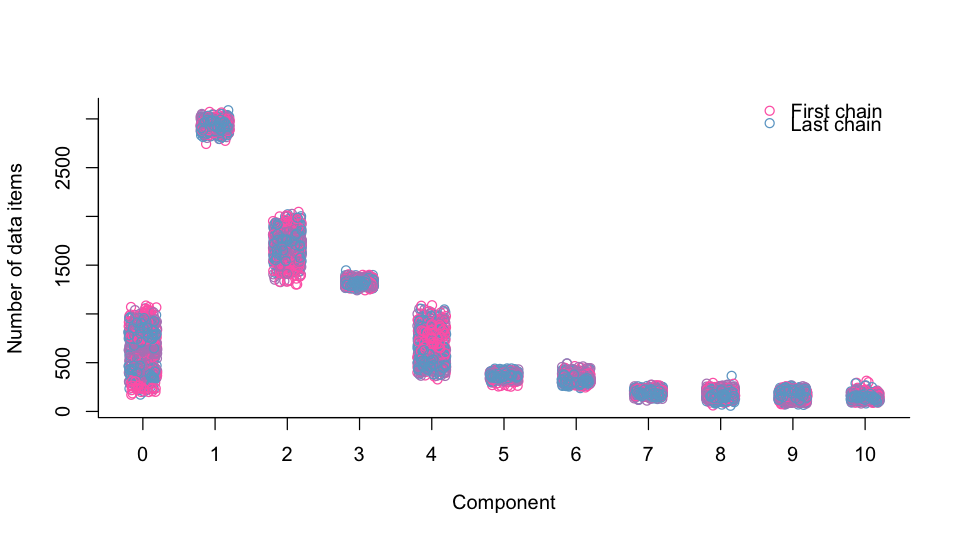

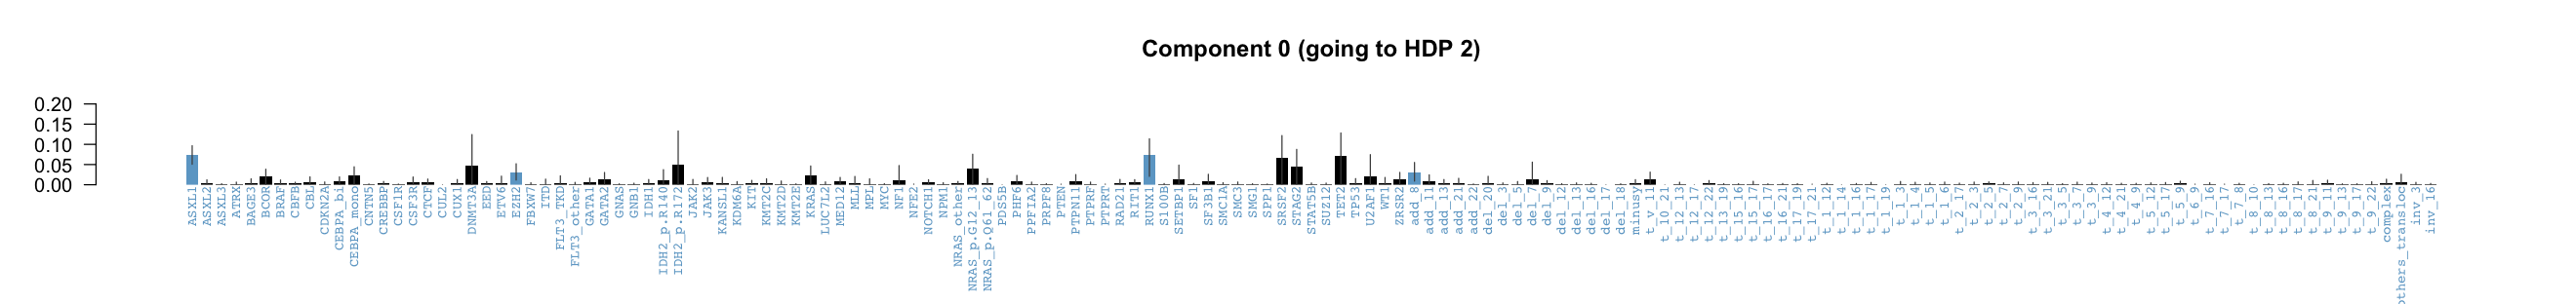

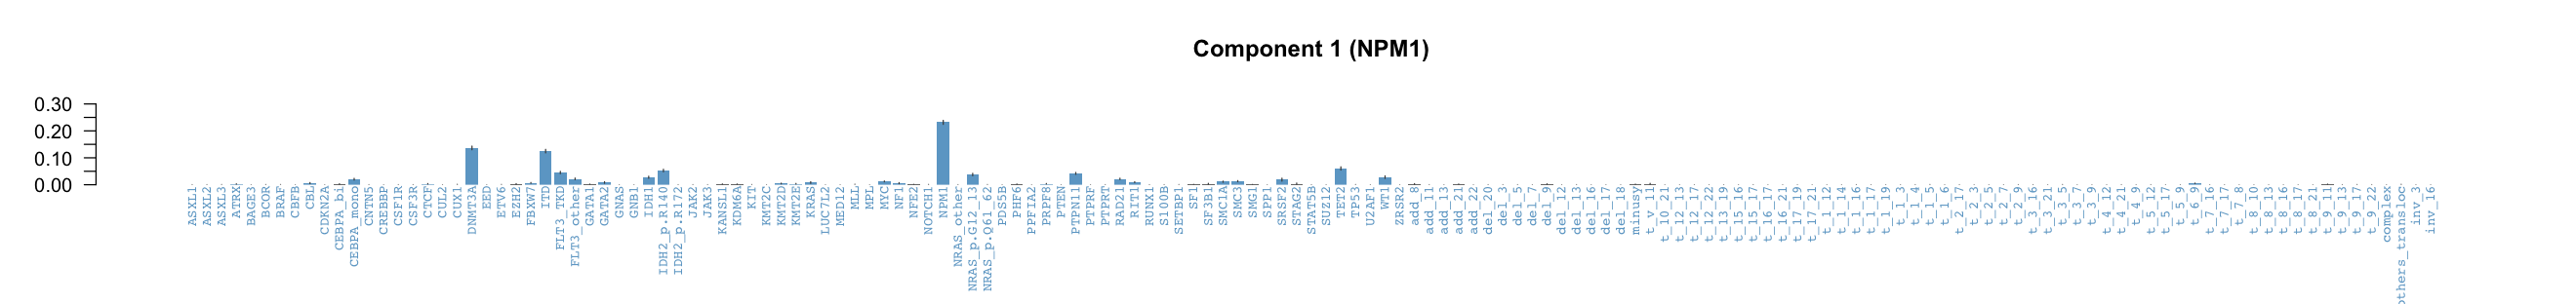

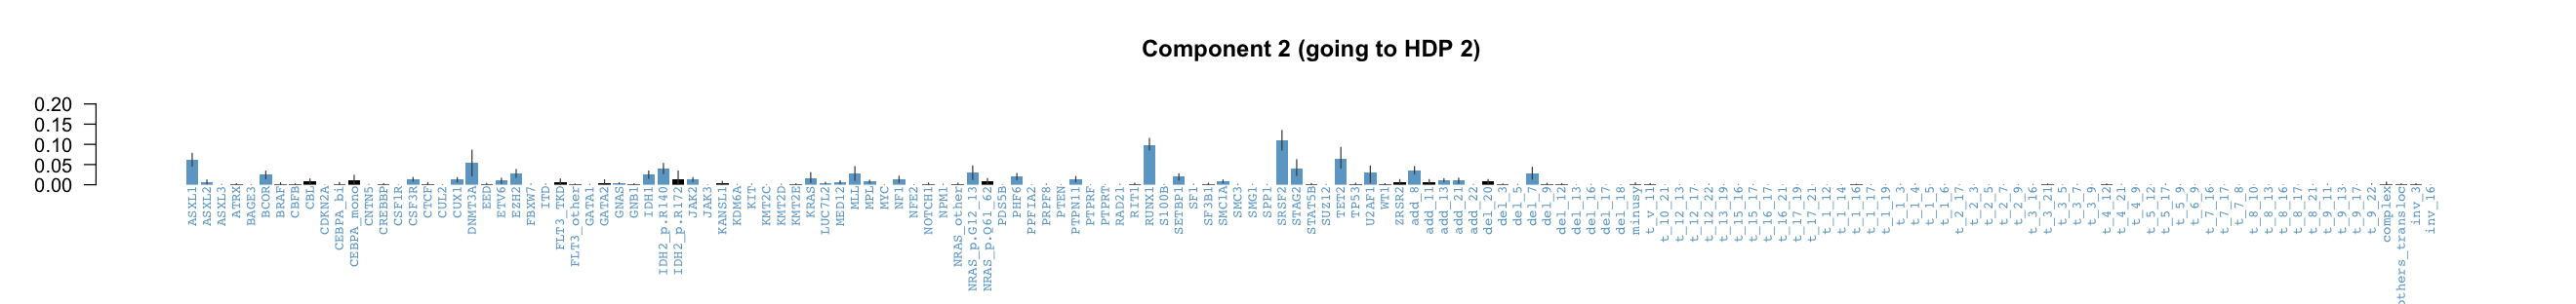

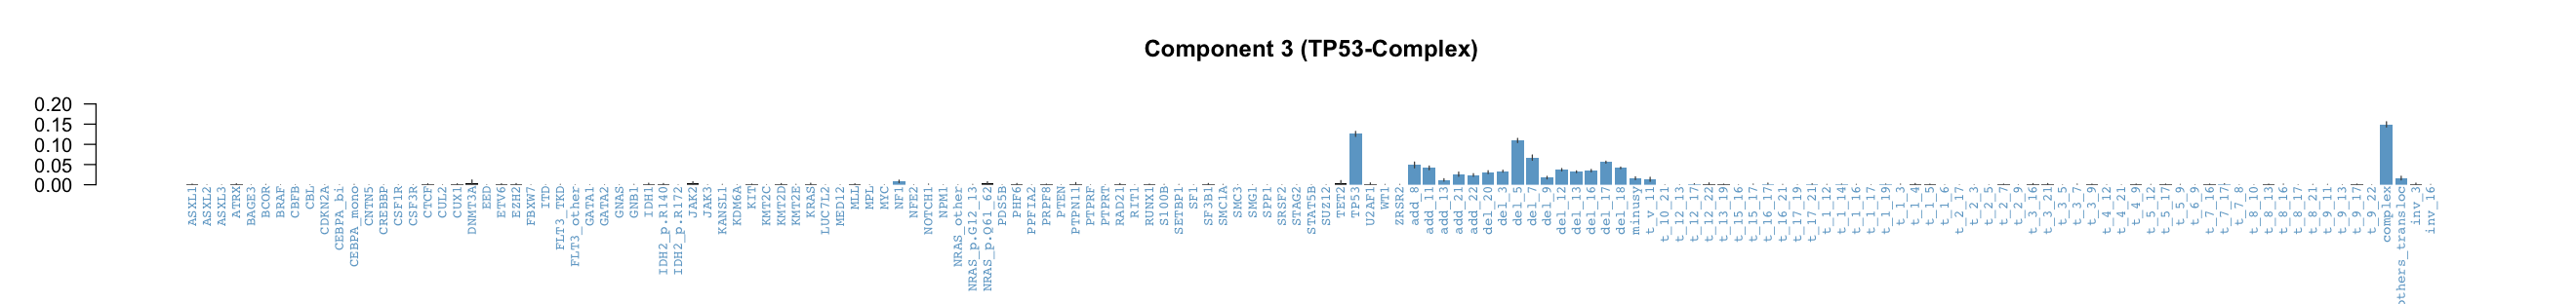

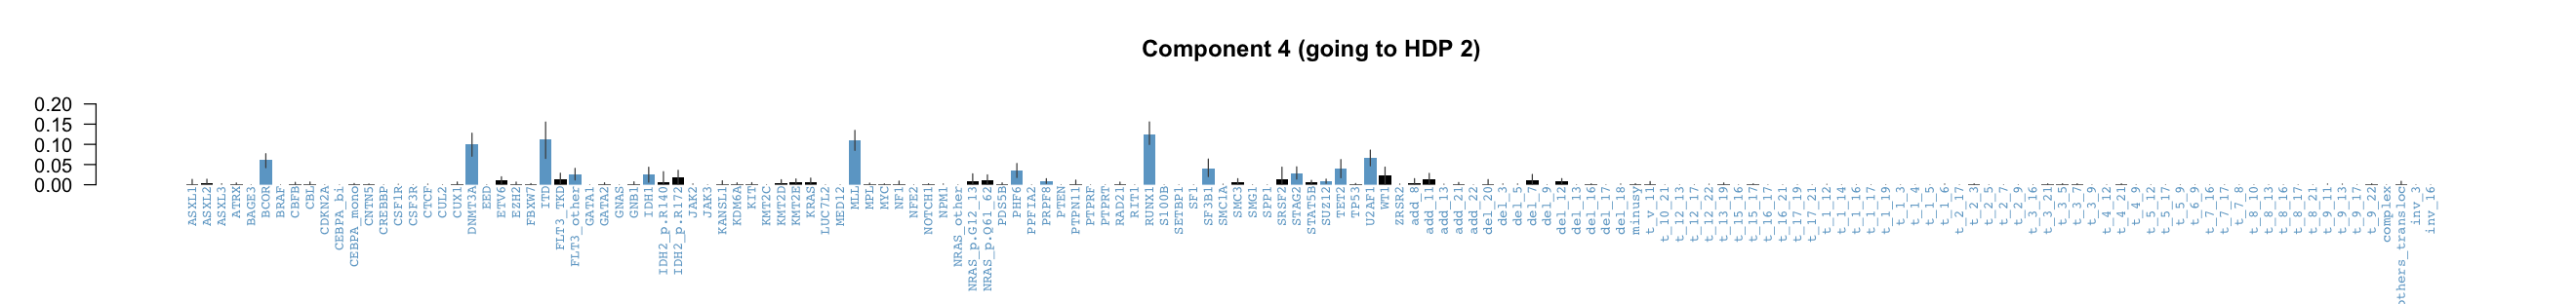

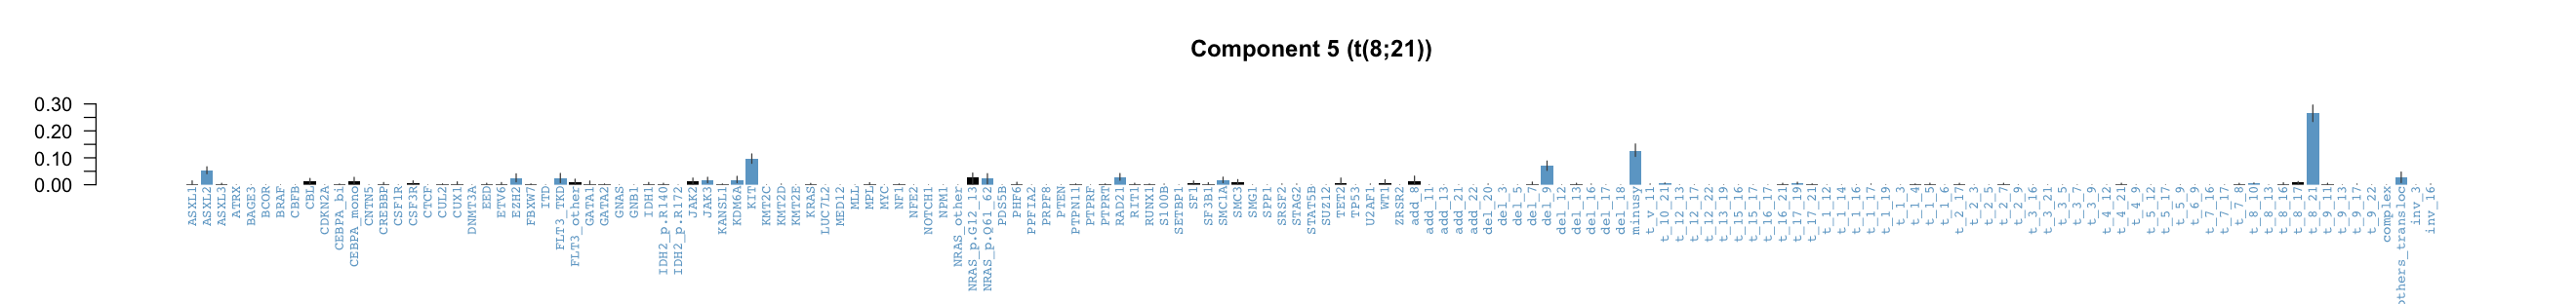

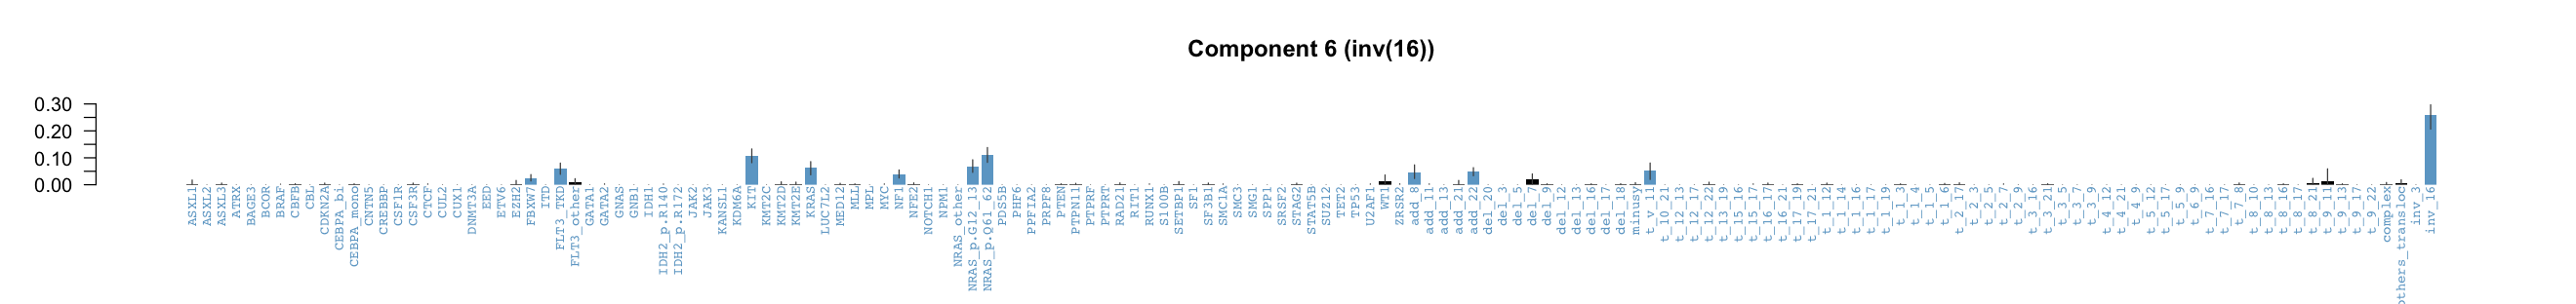

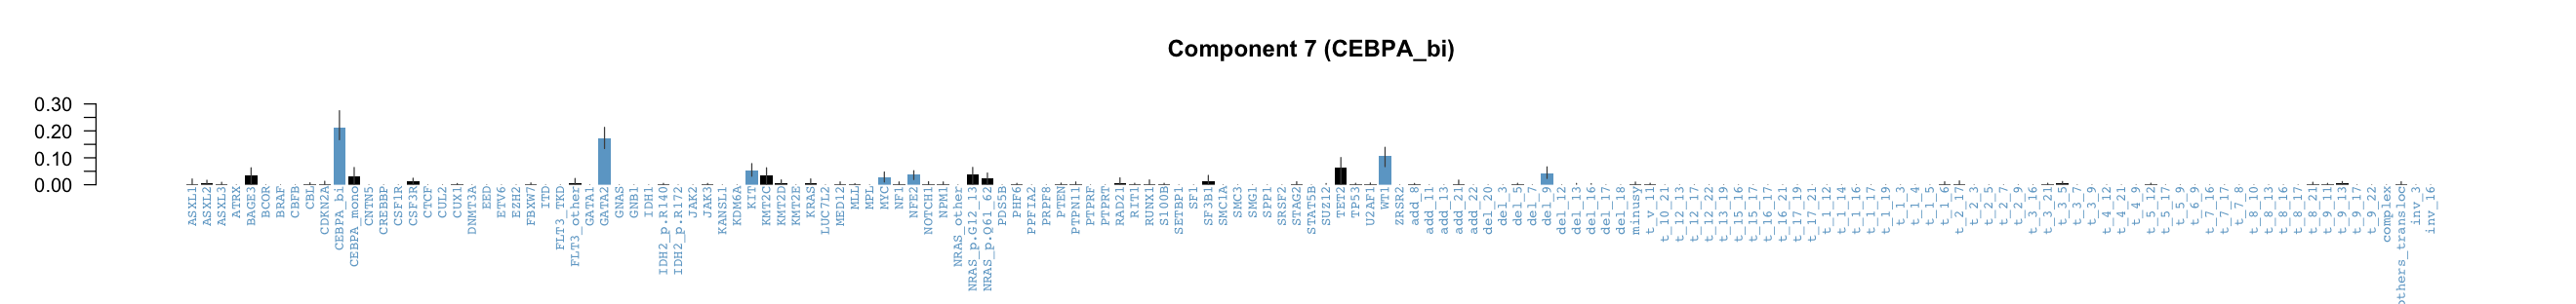

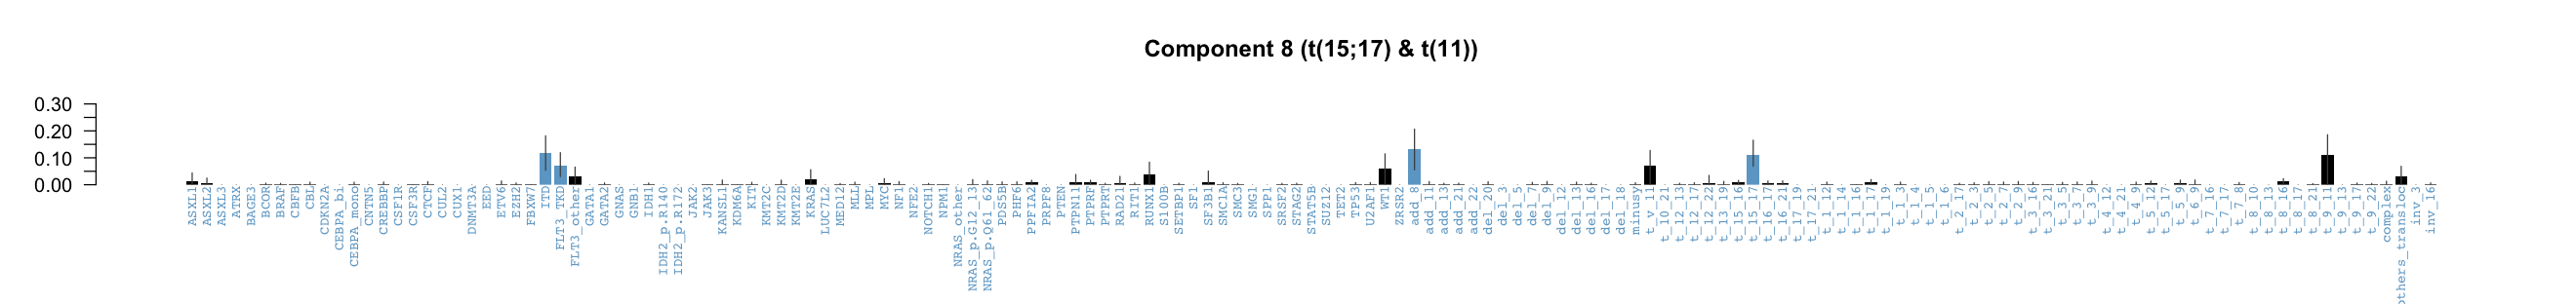

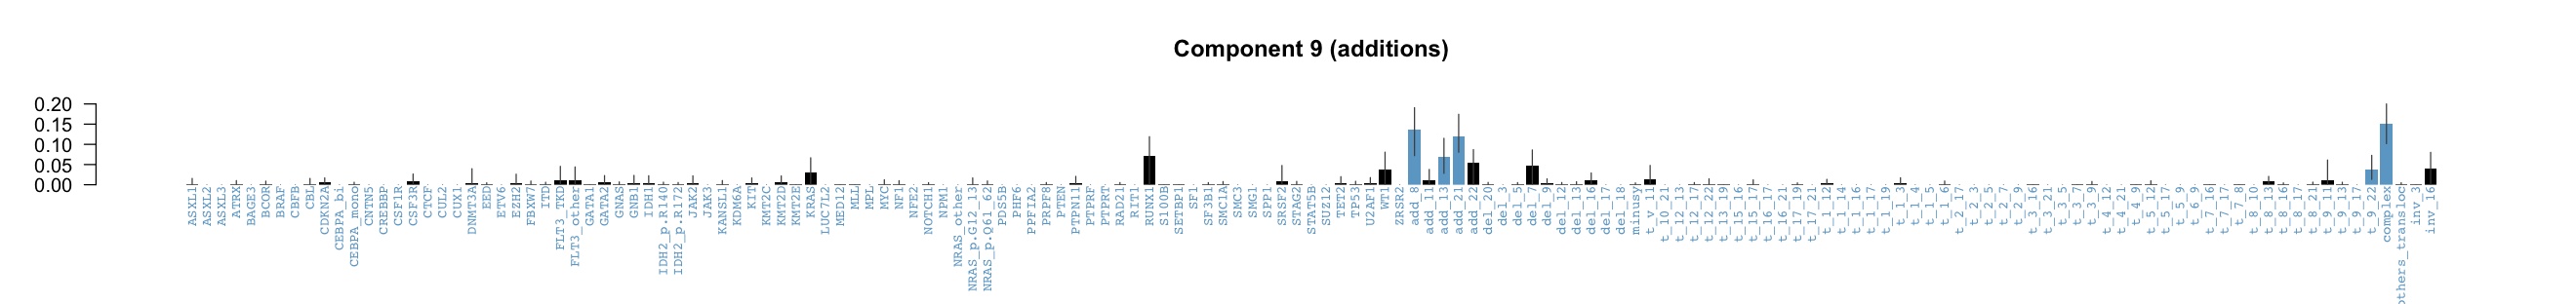

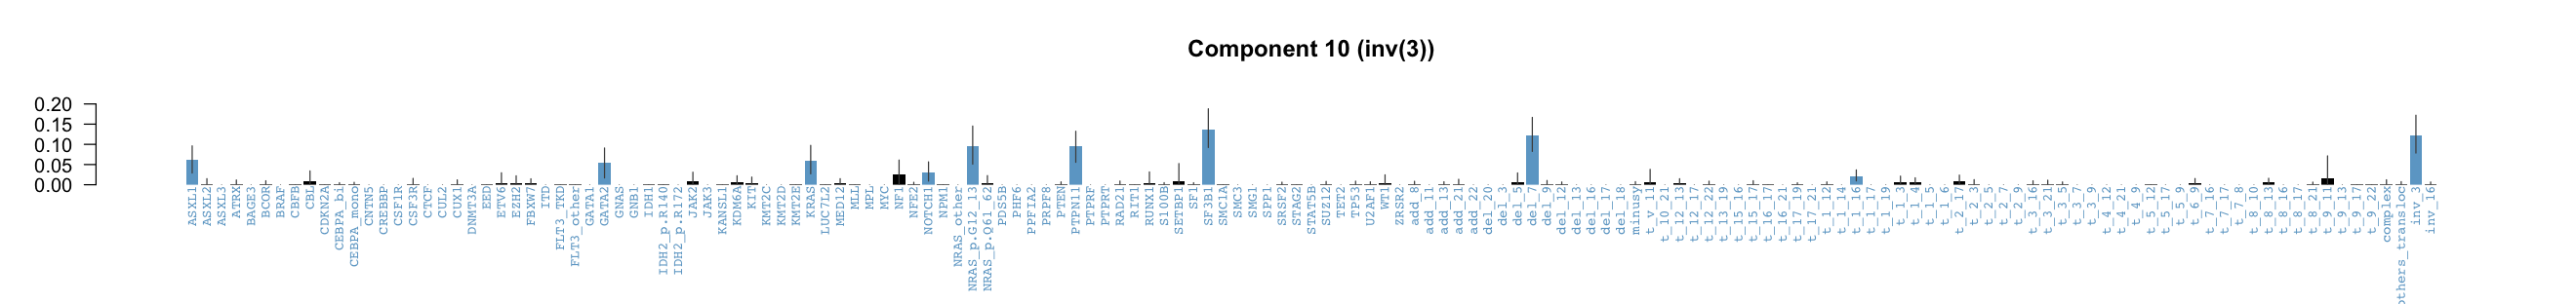

In [12]:
dd_predicted_10_components <- get_prediction_result_dataframe(multi_output_cluster_10, df_hdp1)
tab <- get_table(dd_predicted_10_components[,'predicted_component'])
tab


#plot components

plot_components_size(multi_output_cluster_10,8,4.5)
set_notebook_plot_size(22, 2.6)
plot_comp_distn(multi_output_cluster_10,
                cat_names  = colnames(df_hdp1),
                col        = "skyblue3",
                col_nonsig = "black",
                plot_title=c("Component 0 (going to HDP 2)","Component 1 (NPM1)","Component 2 (going to HDP 2)","Component 3 (TP53-Complex)","Component 4 (going to HDP 2)",
                             "Component 5 (t(8;21))","Component 6 (inv(16))","Component 7 (CEBPA_bi)","Component 8 (t(15;17) & t(11))", "Component 9 (additions)","Component 10 (inv(3))")
                                         )

Number of components: 10
Number of NA rows   : 51


,values,count,freq
,<fct>,<int>,<chr>
2,1,833,38.7441860465116
3,2,418,19.4418604651163
4,3,229,10.6511627906977
5,4,128,5.95348837209302
6,5,114,5.30232558139535
7,6,114,5.30232558139535
1,0,96,4.46511627906977
9,8,61,2.83720930232558
12,NaN,51,2.37209302325581


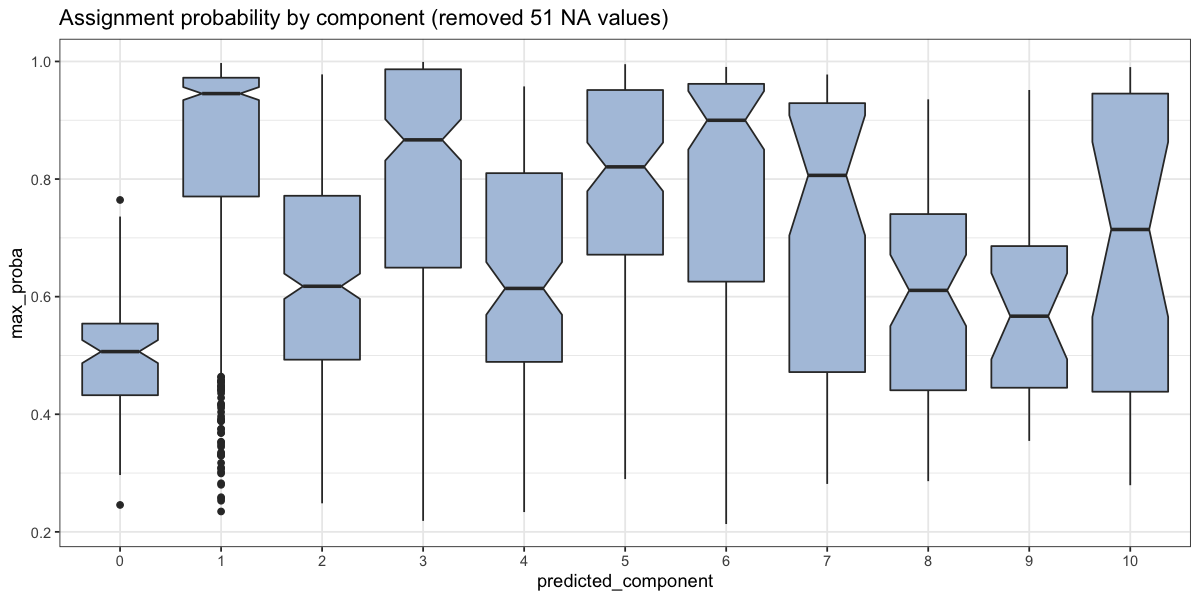

In [33]:
# png("figures/figures_miscellaneous/bdp1_comp.png",width=8000,height=8000,res=200)
dd_predicted_10_components <- get_prediction_result_dataframe(multi_output_cluster_10, df_hdp1)
tab <- get_table(dd_predicted_10_components[,'predicted_component'])
tab



# par(mfrow=c(12,1))
# plot_components_size(multi_output_cluster_10,8,4.5)
# plot_comp_distn(multi_output_cluster_10,
#                 cat_names  = colnames(df_hdp1),
#                 col        = "skyblue3",
#                 col_nonsig = "black",
#                 plot_title=c("Component 0 (going to HDP 2)","Component 1 (NPM1)","Component 2 (going to HDP 2)","Component 3 (TP53-Complex)","Component 4 (going to HDP 2)",
#                              "Component 5 (t(8;21))","Component 6 (inv(16))","Component 7 (CEBPA_bi)","Component 8 (t(15;17) & t(11))", "Component 9 (additions)","Component 10 (inv(3))")
#                                          )
# dev.off()    
# png("figures/figures_miscellaneous/bdp1_proba.png",width=3000,height=800,res=140)
plot_assignement_probability_by_component(dd_predicted_10_components)#+#+scale_fill_manual(values="blue")
# ylab("Max Proba of assignment")+xlab("Predicted Component")   +
#     theme(plot.title=element_text(size=30,face="bold",hjust=0.5),axis.text=element_text(size=20),axis.title=element_text(size=25,face="bold")) +
#     ggtitle("Assignment probability of Top Component")
# dev.off()

In [14]:
# NA Rows correspond to no defining events i.e all columns are 0 for those 51 patients
df_molecular <- read.table("data/aml_molecular_bdp.tsv")
initial_components <- cbind(df_molecular,add_first_second_predicted_component(multi_output_cluster_10))

Number of components: 10
Number of NA rows   : 51


In [15]:
write.table(initial_components,file="data/initial_components_with_proba.tsv",sep='\t')

# Rules : Patients that do not have molecular drivers defined by HDP will be going to HDP 2

# Step 1: Defining feature in each component

In [16]:
tmp <- read.table("data/initial_components_with_proba.tsv")

tmp$initial_refined_component <- "not_assigned"

tmp[tmp$NPM1==1,]$initial_refined_component <- "NPM1"

tmp[tmp$initial_refined_component=="not_assigned" & (tmp$TP53==1 & tmp$complex==1),]$initial_refined_component <- "TP53_complex"

tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==3 & (tmp$TP53==1 | tmp$complex==1),]$initial_refined_component <- "TP53_complex"

tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==5 & tmp$t_8_21==1,]$initial_refined_component <- "t_8_21"

tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==6 & tmp$inv_16==1,]$initial_refined_component <- "inv_16"

tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==7 & tmp$CEBPA_bi==1,]$initial_refined_component <- "CEBPA_bi"

tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==8 & (tmp$t_v_11==1 | tmp$t_9_11==1),]$initial_refined_component <- "t_11"
tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==8 & tmp$t_15_17==1,]$initial_refined_component <- "t_15_17"

tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==9 & (tmp$add_8==1 | tmp$add_11==1 | tmp$add_13==1 | tmp$add_21==1 | tmp$add_22==1),]$initial_refined_component <- "additions"

tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==10 & tmp$inv_3==1,]$initial_refined_component <- "inv_3"

tmp[is.na(tmp$max_proba),]$initial_refined_component <- "no_events"

In [17]:
t(data.frame(table(tmp$initial_refined_component)))


Var1,additions,CEBPA_bi,inv_16,inv_3,no_events,not_assigned,NPM1,t_11,t_15_17,t_8_21,TP53_complex
Freq,21,35,85,13,51,915,682,31,19,99,199


## Patients that did not pass the first test (not defining feature of their component)

In [18]:
table_tmp <- t(data.frame(table(tmp[tmp$initial_refined_component=="not_assigned" & !is.element(tmp$initial_predicted_component,c(0,2,4)),]$initial_predicted_component)))
rownames(table_tmp) <- c("Components","Number of Patients")
cat("Number of patients to test for second max proba in HDP 1: ")
cbind(table_tmp,c("Total",sum(table(tmp[tmp$initial_refined_component=="not_assigned" & !is.element(tmp$initial_predicted_component,c(0,2,4)),]$initial_predicted_component))))


Number of patients to test for second max proba in HDP 1: 

Components,1,3,5,6,7,8,9,10,Total
Number of Patients,160,32,14,29,14,11,5,16,281


# Step 2: Second Max Proba with defining features

In [19]:
### Get Min Proba for each component

min_proba_NPM1 = min(tmp[tmp$initial_predicted_component==1,]$max_proba,na.rm=T)

min_proba_TP53_complex = min(tmp[tmp$initial_predicted_component==3,]$max_proba,na.rm=T)

min_proba_t_8_21 = min(tmp[tmp$initial_predicted_component==5,]$max_proba,na.rm=T)

min_proba_inv_16 = min(tmp[tmp$initial_predicted_component==6,]$max_proba,na.rm=T)

min_proba_CEBPA_bi = min(tmp[tmp$initial_predicted_component==7,]$max_proba,na.rm=T)

min_proba_transloc = min(tmp[tmp$initial_predicted_component==8,]$max_proba,na.rm=T)

min_proba_additions = min(tmp[tmp$initial_predicted_component==9,]$max_proba,na.rm=T)

min_proba_inv_3 = min(tmp[tmp$initial_predicted_component==10,]$max_proba,na.rm=T)

In [20]:
## Refine patients with second max proba

threshold <- 0.75

tmp[tmp$initial_refined_component=="not_assigned"  ,]$initial_refined_component  <- apply(tmp[tmp$initial_refined_component=="not_assigned" ,], 1,function(x) {
        if (all(is.na(x['second_predicted_component'])))
            return(NaN)
        else 
            return(ifelse(x['second_predicted_component']==3 & x['second_max_proba']>=threshold*min_proba_TP53_complex & (x['complex']==1 | x["TP53"]==1),"TP53_complex",
                          
                   ifelse(x['second_predicted_component']==5 & x['second_max_proba']>=threshold*min_proba_t_8_21 & x['t_8_21']==1 ,"t_8_21",
                          
                   ifelse(x['second_predicted_component']==6 & x['second_max_proba']>=threshold*min_proba_inv_16 & x['inv_16']==1,"inv_16", 
                          
                   ifelse(x['second_predicted_component']==7  & x['second_max_proba']>=threshold*min_proba_CEBPA_bi & x['CEBPA_bi']==1,"CEBPA_bi", 
                          
                   ifelse(x['second_predicted_component']==8 & x['second_max_proba']>=threshold*min_proba_transloc & (x['t_v_11']==1 | x['t_9_11']==1),"t_11",
                   ifelse(x['second_predicted_component']==8 & x['second_max_proba']>=threshold*min_proba_transloc & x['t_15_17']==1 ,"t_15_17",
                          
                   ifelse(x['second_predicted_component']==9 & x['second_max_proba']>=threshold*min_proba_additions & (x['add_8']==1 | x['add_11']==1 | x['add_13']==1 | x['add_21']==1 | x['add_22']==1 ),"additions",
                          
                   ifelse(x['second_predicted_component']==10 & x['second_max_proba']>=threshold*min_proba_inv_3 & x['inv_3']==1,"inv_3",       
                   "not_assigned")))))))))
    })
t(data.frame(table(tmp$initial_refined_component)))

Var1,additions,CEBPA_bi,inv_16,inv_3,no_events,not_assigned,NPM1,t_11,t_15_17,t_8_21,TP53_complex
Freq,24,39,88,13,51,888,682,41,20,99,205


In [21]:
write.table(tmp,"data/bdp1_assignment.tsv",sep='\t')

## Patients in category not assigned do not have defining features of their component nor of their second predicted component. They will also go in BDP 2.

# II- BDP2 : BDP reapplied on 888 Patients

## 888 Patients from Component 0,2 and 4 + Patients from other components that do not have defining features from their component.

In [22]:
hdp1_assignment <- read.table('data/bdp1_assignment.tsv')

# We reapply HDP to those patients :

df_to_recluster <- hdp1_assignment[hdp1_assignment$initial_refined_component=="not_assigned",c(genes_columns,cytos_columns)]   ## Reapply HDP only on not assigned patients and keep only gene and cyto columns


In [23]:
num_cols = ncol(df_to_recluster[colSums(df_to_recluster) > 0])  ## keep only column that have at least a mutation (otherwise HDP is not applicable)
num_cols
bin <- function(x){
    set.seed(123)
  (rbinom(1, num_cols, mean(x))+1)/num_cols
}

###Normal

normal <- function(x){
    set.seed(123)
  abs(rnorm(1,mean(x),sd(x)))
}

###Poisson

poisson <- function(x){
    set.seed(123)
  (rpois(num_cols,1)+1)/num_cols
}

###Uniform equally over all columns

equally <- function(x){
    set.seed(123)
  1/num_cols
}

###Repet 1

repet <- function(x){
    set.seed(123)
  1
}

binomial <- unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],bin))
gaussian <- unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],normal))
pois <- as.numeric(unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],poisson)))
unif <- unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],equally))

[1] 129

In [24]:
# HDP2 Parameters

data <- df_to_recluster[colSums(df_to_recluster) > 0]
posterior_samples <- 150
initial_clusters <- 5
burn <- 5000
chains <- 3
base_dist <- prepare_distributions(df_to_recluster[colSums(df_to_recluster) > 0])$gaussian
aa <- 2
ab <-6


In [25]:
multi_output <- launch(df_to_recluster[colSums(df_to_recluster) > 0],base_dist,initial_clusters,burn,posterior_samples,chains,aa,ab)

multi_output_recluster_5 <- extract_components(multi_output)

Initialise HDP on a 888 x 129 dataframe
  → create HDP structure... done!
  → add DP node for each patient... done!
  → assign the data to the nodes... done!
### Experiment 1 (seed = 100) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "5000 burn-in iterations in 0.2 mins"

### Experiment 2 (seed = 200) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "5000 burn-in iterations in 0.2 mins"

### Experiment 3 (seed = 300) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "5000 burn-in iterations in 0.2 mins"

Object of class hdpSampleMulti 
 Number of chains: 3 
 Total posterior samples: 450 
 Components: NO. Run hdp_extract_components 
 ----------
 Final hdpState from first chain: 
Object of class hdpState 
 Number of DP nodes: 889 
 Index of parent DP: 0 1 1 1 1 1 1 1 1 1 ...
 Number of da

Number of components: 5
Number of NA rows   : 0


,values,count,freq
,<fct>,<int>,<chr>
2,1,319,35.9234234234234
3,2,228,25.6756756756757
1,0,144,16.2162162162162
4,3,101,11.3738738738739
6,5,62,6.98198198198198
5,4,34,3.82882882882883
11,-- total --,888,100%


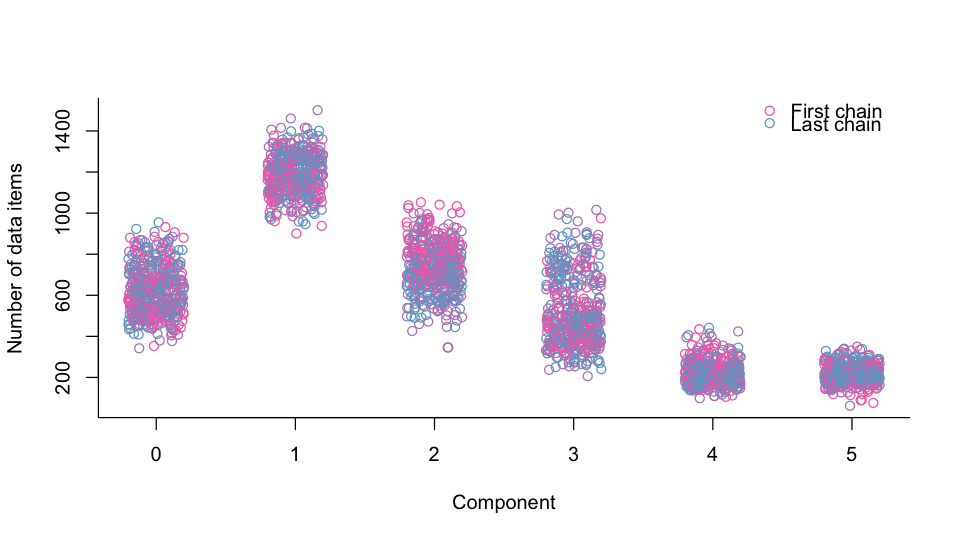

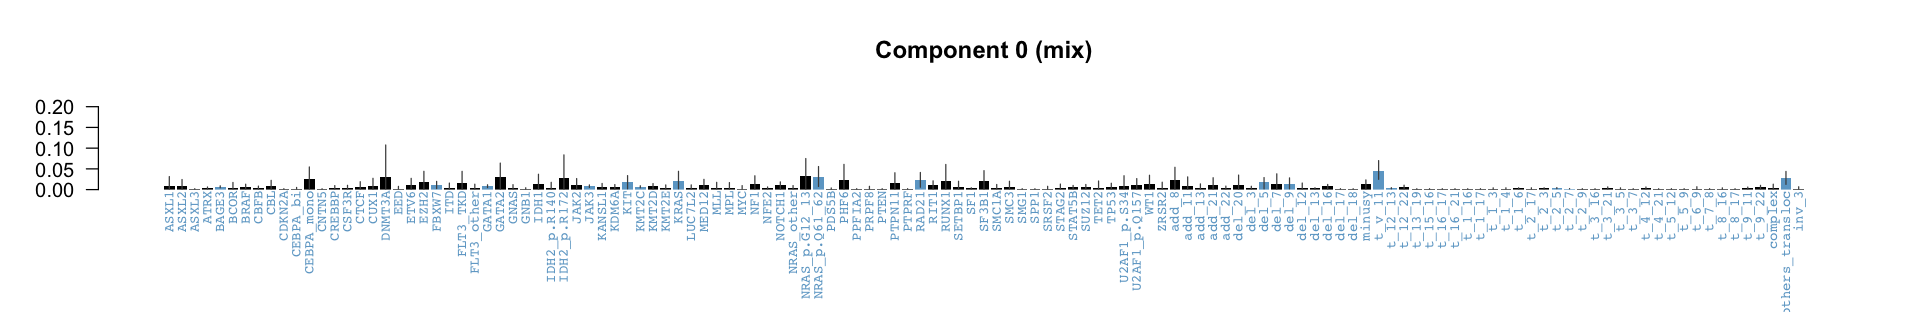

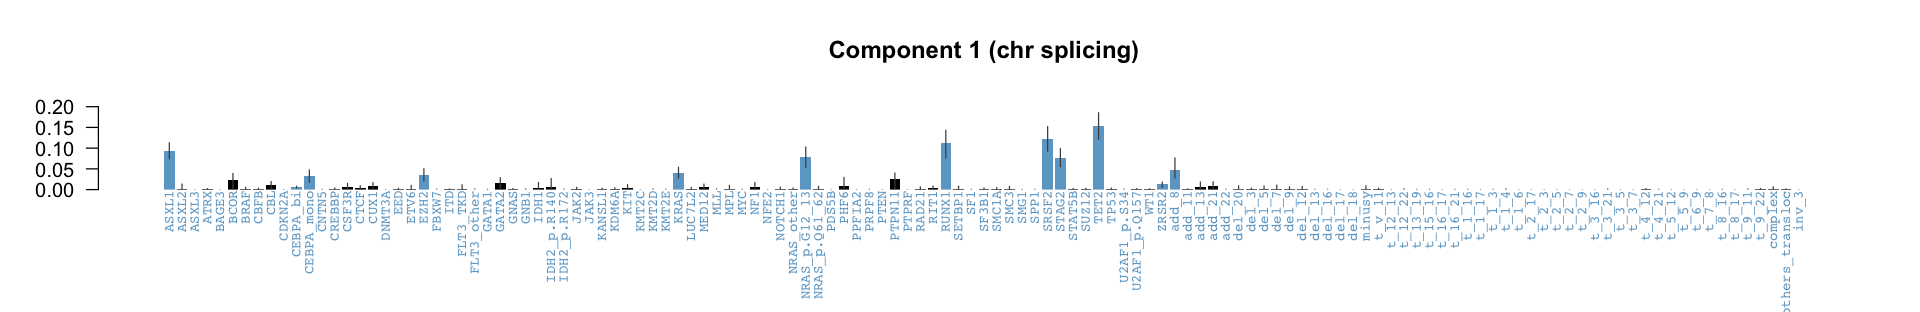

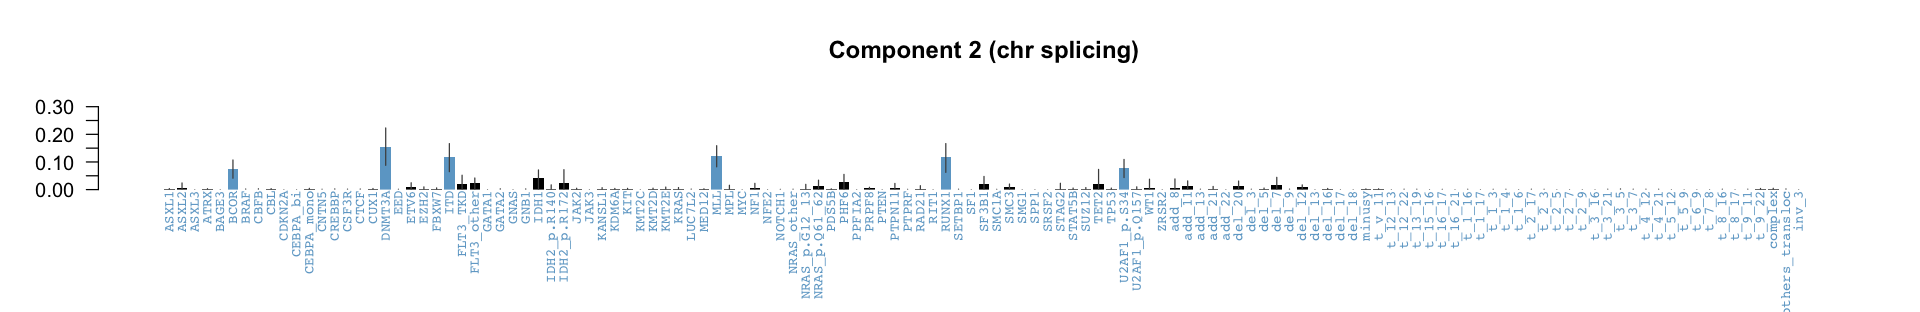

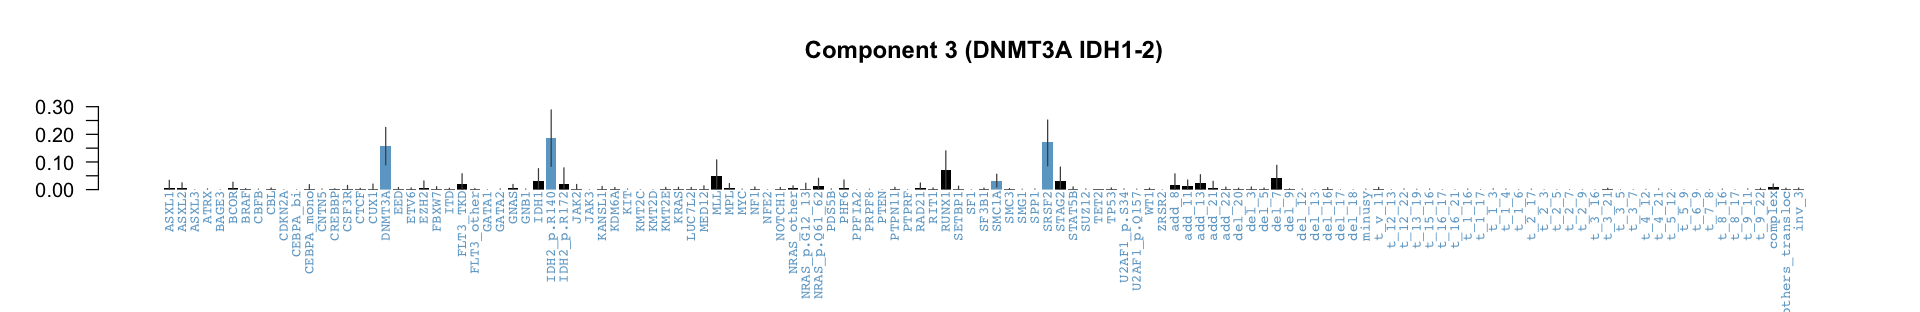

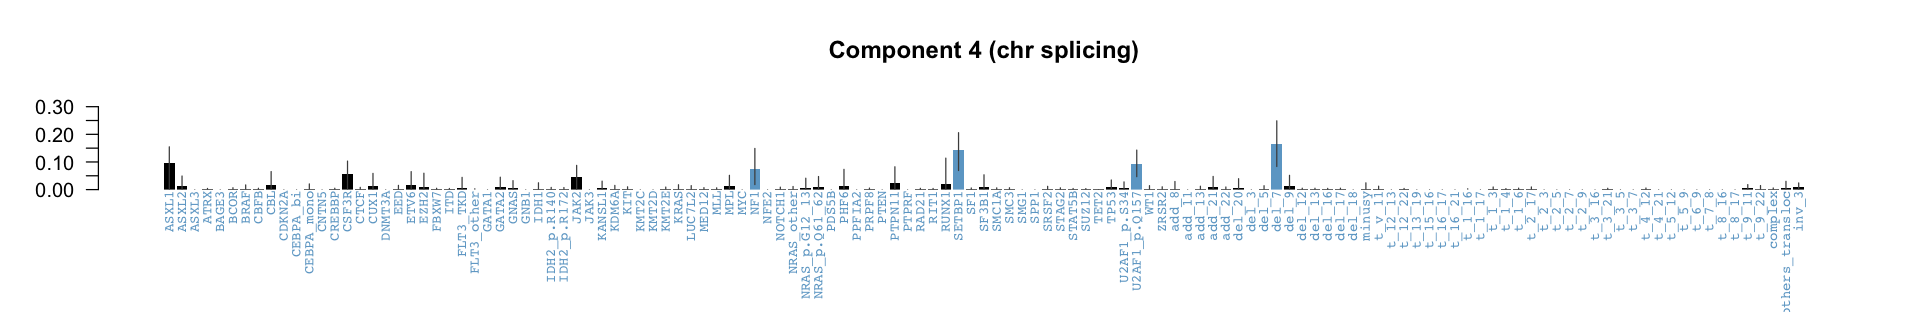

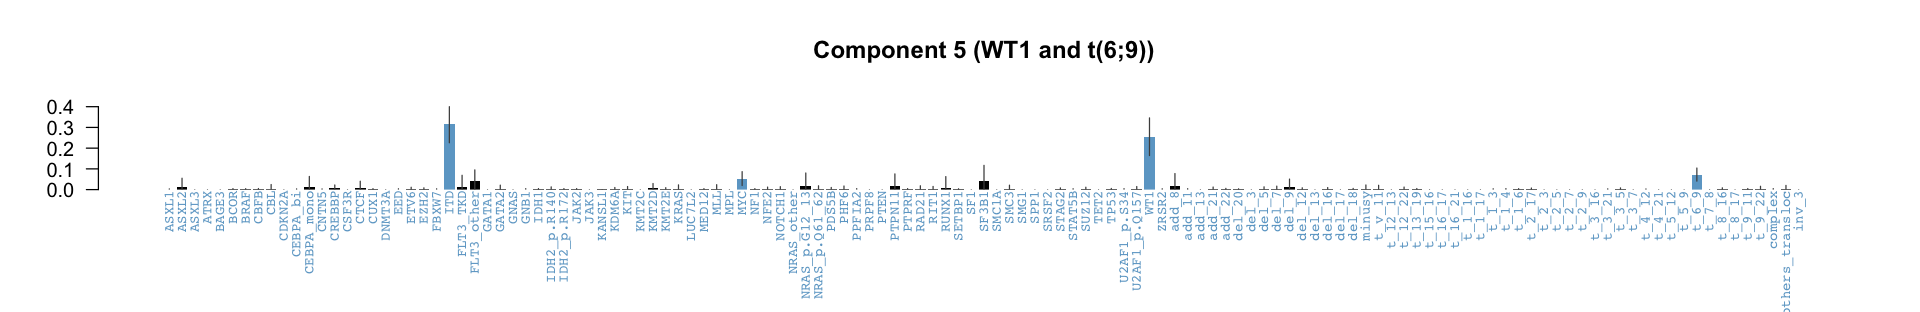

In [26]:
dd_predicted_5_components <- get_prediction_result_dataframe(multi_output_recluster_5, df_final)

tab <- get_table(dd_predicted_5_components[,'predicted_component'])

tab

plot_components_size(multi_output_recluster_5,8,4.5)

set_notebook_plot_size(16,2.6)

plot_comp_distn(multi_output_recluster_5,
                    cat_names  = colnames(df_to_recluster[colSums(df_to_recluster) > 0]),
                    col        = "skyblue3",
                    col_nonsig = "black",
                    plot_title=c("Component 0 (mix)","Component 1 (chr splicing)","Component 2 (chr splicing)","Component 3 (DNMT3A IDH1-2)","Component 4 (chr splicing)","Component 5 (WT1 and t(6;9))"))
                                 
                                 
                                 

In [27]:
# png("figures/figures_miscellaneous/bdp2_comp.png",width=8000,height=8000,res=200)
dd_predicted_5_components <- get_prediction_result_dataframe(multi_output_recluster_5, df_final)

tab <- get_table(dd_predicted_5_components[,'predicted_component'])

tab



# par(mfrow=c(12,1))
# plot_components_size(multi_output_recluster_5,8,4.5)
# plot_comp_distn(multi_output_recluster_5,
#                     cat_names  = colnames(df_to_recluster[colSums(df_to_recluster) > 0]),
#                     col        = "skyblue3",
#                     col_nonsig = "black",
#                     plot_title=c("Component 0 (mix)","Component 1 (chr splicing)","Component 2 (chr splicing)","Component 3 (DNMT3A IDH1-2)","Component 4 (chr splicing)","Component 5 (WT1 and t(6;9))"))

# dev.off()    
# png("figures/figures_miscellaneous/bdp2_proba.png",width=3000,height=800,res=140)
# plot_assignement_probability_by_component(dd_predicted_5_components)+#+scale_fill_manual(values="blue")
# ylab("Max Proba of assignment")+xlab("Predicted Component")   +
#     theme(plot.title=element_text(size=30,face="bold",hjust=0.5),axis.text=element_text(size=20),axis.title=element_text(size=25,face="bold")) +
#     ggtitle("Assignment probability of Top Component")
# dev.off()

Number of components: 5
Number of NA rows   : 0


,values,count,freq
,<fct>,<int>,<chr>
2,1,319,35.9234234234234
3,2,228,25.6756756756757
1,0,144,16.2162162162162
4,3,101,11.3738738738739
6,5,62,6.98198198198198
5,4,34,3.82882882882883
11,-- total --,888,100%


notch went outside hinges. Try setting notch=FALSE.



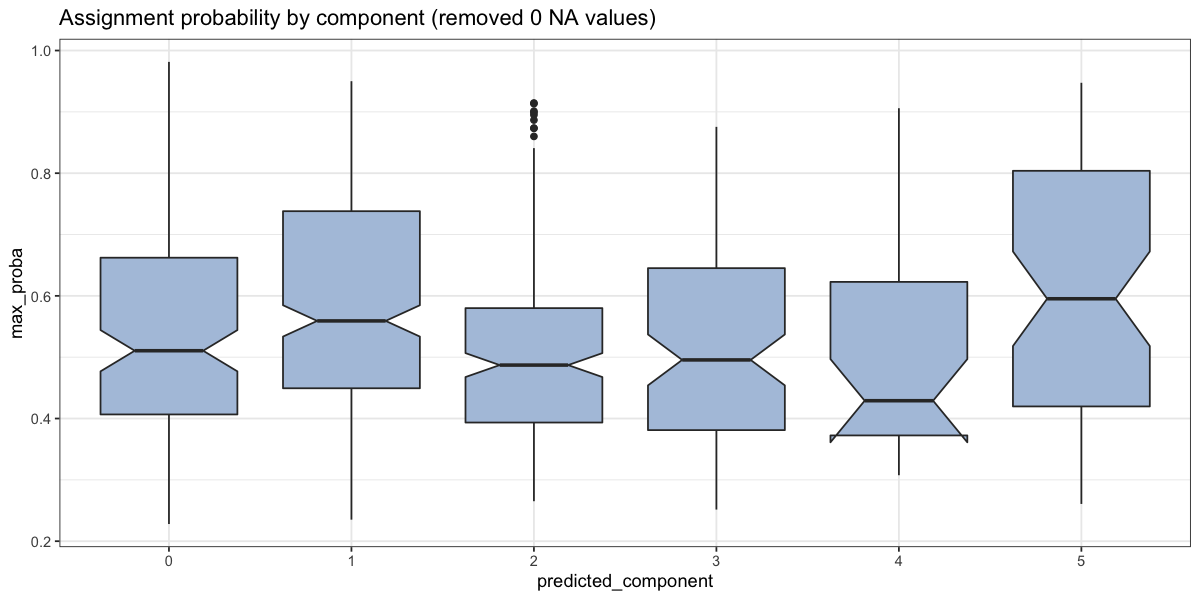

In [28]:
plot_assignement_probability_by_component(dd_predicted_5_components)